# Example 6 - Multi-objective optimization for an ellipse function

In this example, we will demonstrate how Bayesian Optimization can perform multi-objective optimization (MOO) and create a Pareto front. We will use a hyperthetical function which has a shape of an ellispe:

$$ y_1 = x $$
$$ y_2 = \sqrt{(1 - x^2/4)} $$

where 
$$ y_1^2 + y_2^2/4 = 1 $$

`x` is the only input parameter. `y1` and `y2` are two output reponses which cannot be optimized jointly. 

Multi-objective optimization derives a set of solutions that define the tradeoff between competing objectives. The boundary defined by the entire feasible solution set is called the Pareto front. 

In `nextorch`, we implement weighted sum method to construct the Pareto front. It is commonly used for convex problems. A set of objectives are scalarized to a single objective by adding each objective pre-multiplied by a user-supplied weight. The weight of an objective is chosen in proportion to its relative importance. The optimization is simply performed with respected to the scalarized objective. By varying the weight combinations, we can construct the whole Pareto front. 

For this example, the scalarized objective can be written as,
$$ y = w_1 y_1 + w_2 y_2 $$
where the weights 
$$ w_1, w_2 \in [0, 1] $$
$$w_1 + w_2 = 1 $$

The details of this example is summarized in the table below:

| Key Item      | Description |
| :----------------- | :----------------- |
| Goal | Maximization, two objectives |
| Objective function | Ellipse function |
| Input (X) dimension | 1 |
| Output (Y) dimension | 2 |
| Analytical form available? | Yes |
| Acqucision function | Expected improvement (EI) |
| Initial Sampling | Latin hypercube | 

Next, we will go through each step in Bayesian Optimization.

## 1. Import `nextorch` and other packages

In [7]:
import time
import numpy as np
from nextorch import plotting, bo, doe, utils, io

## 2. Define the objective function and the design space
We import the PFR model, and wrap it in a Python function called `PFR` as the objective function `objective_func`. 

The ranges of the input X are specified. 

In [8]:
#%% Define the objective function
def ellipse(X_real):
    """ellipse function

    Parameters
    ----------
    X_real : numpy matrix
        input parameter

    Returns
    -------
    Y_real: numpy matrix
        y1 and y2
    """
    if len(X_real.shape) < 2:
        X_real = np.expand_dims(X_real, axis=1) #If 1D, make it 2D array
        
    y1 = X_real.copy()
    y2 = np.sqrt(1 - X_real**2/4)
    
    Y_real = np.concatenate((y1, y2), axis = 1)
        
    return Y_real # y1, y2


# Objective function
objective_func = ellipse


#%% Define the design space
X_name = ['x']
    
# two outputs
Y_names = [r'$\rm y_1$', r'$\rm y_2$']

# combine X and Y names
var_names = X_name + Y_names

# Set the operating range for each parameter
X_ranges =  [[0, 2]]

# Get the information of the design space
n_dim = 1 # the dimension of inputs
n_objective = 2 # the dimension of outputs

## 3. Define the initial sampling plan
Here we use LHC design with 10 points for the initial sampling. The initial reponse in a real scale `Y_init_real` is computed from the objective function.

In [9]:
#%% Initial Sampling 
# Latin hypercube design with 10 initial points
n_init_lhc = 10
X_init_lhc = doe.latin_hypercube(n_dim = n_dim, n_points = n_init_lhc, seed= 1)
# Get the initial responses
Y_init_lhc = bo.eval_objective_func(X_init_lhc, X_ranges, objective_func)

## 4. Initialize an `Experiment` object 

In this example, we use an `WeightedMOOExperiment` object, a class designed for multi-objective optimization. It can handle multiple weight combinations, perform the scalarized objective optimization automatically, and construct the entire Pareto front. 

An `WeightedMOOExperiment` is a subclass of `Experiment`. It requires all key components as `Experiment`:
- Name of the experiment, used for output folder name
- Input independent variables X: `X_init` or `X_init_real`
- List of X ranges: `X_ranges`
- Output dependent variables Y: `Y_init` or `Y_init_real`

Optional:
- `unit_flag`: `True` if the input X matrix is a unit scale, else `False`
- `objective_func`: Used for test plotting
- `maximize`: `True` if we look for maximum, else `False` for minimum

Additionally, `weights` is required for `WeightedMOOExperiment.set_optim_specs` function. It defines a list of weights for objective 1. The weights of objective 2 is 1 minus that of objective 1. Under the hood, each weight combination correponds to a single `Experiment` object, each with a different scalarized objective. 

Some progress status will be printed out while initializing all single `Experiment` objects.

In [10]:
#%% Initialize an multi-objective Experiment object
# Set its name, the files will be saved under the folder with the same name
Exp_lhc = bo.WeightedMOOExperiment('ellipse_MOO')  
# Import the initial data
Exp_lhc.input_data(X_init_lhc, 
                   Y_init_lhc, 
                   X_ranges = X_ranges, 
                   X_names = X_name,
                   Y_names = Y_names,
                   unit_flag = False)

# Set the optimization specifications 
# here we set the objective function, minimization by default
# 10 weights, 10 Experiments
n_exp = 21 # number of single Experiments

# Set a weight vector for objective 1
weights_obj_1 = np.linspace(0, 1, n_exp)
weights_obj_2 = 1 - weights_obj_1

# Set a timer
start_time = time.time()
Exp_lhc.set_optim_specs(objective_func = objective_func, 
                        maximize = True, 
                        weights = weights_obj_1)
end_time = time.time()
print('Initializing {} Experiments takes {:.2f} minutes.'.format(n_exp, (end_time-start_time)/60))

Initializing 21 experiments
Iter 10/100: 5.723519325256348
Iter 20/100: 5.232956886291504
Iter 30/100: 4.613386154174805
Iter 40/100: 1.9704792499542236
Iter 50/100: 1.512966513633728
Iter 60/100: 1.4102624654769897
Iter 70/100: 1.3249999284744263
Iter 80/100: 1.2746305465698242
Iter 90/100: 1.2467479705810547
Iter 100/100: 1.225650668144226
Initializing experiments 4.76 % 
Iter 10/100: 5.723519325256348
Iter 20/100: 5.232956886291504
Iter 30/100: 4.613386154174805
Iter 40/100: 1.9704792499542236
Iter 50/100: 1.512966513633728
Iter 60/100: 1.4102624654769897
Iter 70/100: 1.3249999284744263
Iter 80/100: 1.2746305465698242
Iter 90/100: 1.2467479705810547
Iter 100/100: 1.225650668144226
Initializing experiments 9.52 % 
Iter 10/100: 5.723519325256348
Iter 20/100: 5.232956886291504
Iter 30/100: 4.613386154174805
Iter 40/100: 1.9704792499542236
Iter 50/100: 1.512966513633728
Iter 60/100: 1.4102624654769897
Iter 70/100: 1.3249999284744263
Iter 80/100: 1.2746305465698242
Iter 90/100: 1.2467479

## 5. Run trials 

At each weight combinations, we perform an optimization task for the scalarized objective (a single `Experiment`). `WeightedMOOExperiment.run_exp_auto` run these tasks automatically by using the default choice of acqucision function, Expected improvement (EI). It takes in the number of trials required for each `Experiment`. The number of trials needs to be large enough which allows Bayesian Optimization algorithm to converge to the optimum. Nevertheless, the optimization of `y1` and `y2` are rather trivial due to their simple analytical expression. We will do 10 trials for each experiment. The total number of calls for the objective function is `n_trails` * `n_exp` (=210). 

Some progress status will be printed out during the training.

In [11]:
# Set the number of iterations for each experiments
n_trials_lhc = 10 
# Set a timer
start_time = time.time()
Exp_lhc.run_exp_auto(n_trials_lhc)

end_time = time.time()
print('Optimizing {} Experiments takes {:.2f} minutes.'.format(n_exp, (end_time-start_time)/60))

Running 21 experiments
Iter 10/100: 0.6268913745880127
Iter 20/100: 0.6080061197280884
Iter 30/100: 0.5958243608474731
Iter 40/100: 0.5888171195983887
Iter 50/100: 0.5849026441574097
Iter 60/100: 0.5811474323272705
Iter 70/100: 0.5798935294151306
Iter 80/100: 0.5778980255126953
Iter 90/100: 0.5769942998886108
Iter 100/100: 0.5764856338500977
Iter 10/100: -0.033872902393341064
Iter 20/100: -0.035207390785217285
Iter 10/100: -0.5689945220947266
Iter 10/100: -1.0354827642440796
Iter 10/100: -0.7298715114593506
Iter 20/100: -0.7343025207519531
Iter 30/100: -0.7352707386016846
Iter 40/100: -0.736293613910675
Iter 10/100: 1.1797966957092285
Iter 10/100: 0.6048701405525208
Iter 10/100: 0.4924396872520447
Iter 10/100: 0.27277737855911255
Iter 10/100: 0.07920187711715698
Running experiments 4.76 % 
Iter 10/100: 1.3681230545043945
Iter 20/100: 1.3586927652359009
Iter 30/100: 1.3537731170654297
Iter 40/100: 1.352138638496399
Iter 50/100: 1.3514869213104248
Iter 10/100: 0.8164217472076416
Iter 10/

Iter 10/100: 2.84079909324646
Iter 10/100: 3.9083783626556396
Iter 10/100: 3.6155099868774414
Iter 10/100: 3.472865343093872
Iter 10/100: 3.3664140701293945
Iter 10/100: 3.005737781524658
Iter 10/100: 3.1068363189697266
Iter 10/100: 3.2274274826049805
Iter 20/100: 3.19210147857666
Iter 30/100: 3.1876795291900635
Iter 40/100: 3.181887149810791
Iter 10/100: 3.100501537322998
Running experiments 66.67 % 
Iter 10/100: 1.3681230545043945
Iter 20/100: 1.3586927652359009
Iter 30/100: 1.3537731170654297
Iter 40/100: 1.352138638496399
Iter 50/100: 1.3514869213104248
Iter 10/100: 2.7783145904541016
Iter 10/100: 3.8912203311920166
Iter 10/100: 3.555548667907715
Iter 10/100: 3.453873634338379
Iter 10/100: 3.447695016860962
Iter 10/100: 3.2042813301086426
Iter 10/100: 2.876983165740967
Iter 20/100: 2.7637088298797607
Iter 30/100: 2.526716709136963
Iter 40/100: 2.516010284423828
Iter 50/100: 2.5086259841918945
Iter 60/100: 2.5029947757720947
Iter 70/100: 2.499117136001587
Iter 80/100: 2.497764587402

## 6. Visualize the Pareto front
We can get the Pareto set directly from the `WeightedMOOExperiment` object by using `WeightedMOOExperiment.get_optim`.

To visualize the Pareto front, `y1` values are plotted against `y2` values. The scatter points resemble an ellispe shape, incidating the method is able to map out the entire front. 

,$\rm w_1$,$\rm w_2$,x,$\rm y_1$,$\rm y_2$
0,0.00,1.00,0.00,0.00,1.00
1,0.05,0.95,0.27,0.27,0.99
2,0.10,0.90,0.20,0.40,0.98
3,0.15,0.85,0.33,0.66,0.94
4,0.20,0.80,0.41,0.83,0.91
5,0.25,0.75,1.13,1.13,0.83
6,0.30,0.70,1.33,1.33,0.75
7,0.35,0.65,0.73,1.47,0.68
8,0.40,0.60,1.56,1.56,0.62
9,0.45,0.55,0.84,1.68,0.54


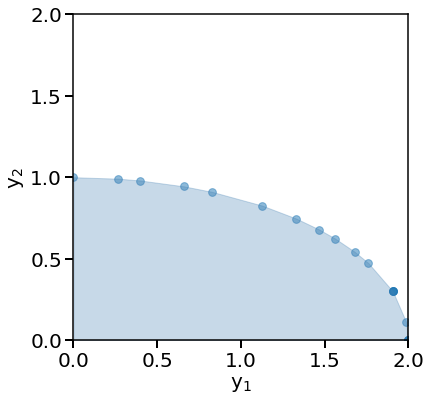

In [12]:
# Extract the set of optimal solutions
Y_real_opts, X_real_opts = Exp_lhc.get_optim()
weight_names = [r'$\rm w_1$', r'$\rm w_2$'] 

# Parse the optimum into a table
data_opt = io.np_to_dataframe([weights_obj_1, weights_obj_2, X_real_opts, Y_real_opts], weight_names + var_names, n = n_exp)
display(data_opt.round(decimals=2))

# Make the pareto plots 
plotting.pareto_front_exp(Exp_lhc, fill = True, diagonal = False)

[Thumbnail](_images/06.png) of this notebook